In [1]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

#for data handaling
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 

#for image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#for calc accuaracy and spliting the data
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
PATH='/kaggle/input/bengaliai-cv19/'
HEIGHT = 137

Using TensorFlow backend.


In [2]:
PATH='/kaggle/input/bengaliai-cv19/'
HEIGHT = 137
WIDTH = 236
SIZE = 64
batch_size = 256
epochs = 64

In [3]:
def crop_resize_image(image_df):
    cropped_resized_img={}
    for i in tqdm(range(len(image_df))):
        image=image_df.iloc[i].values.reshape(HEIGHT,WIDTH)
        _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        x_min=[]
        x_max=[]
        y_min=[]
        y_max=[]
        for cordinate in contours:
            x,y,w,h=cv2.boundingRect(cordinate)
            x_min.append(x)
            x_max.append(x+w)
            y_min.append(y)
            y_max.append(y+h)
        x1=min(x_min)
        x2=max(x_max)
        y1=min(y_min)
        y2=max(y_max)
        cropped_img=image[y1:y2,x1:x2]
        resized_img=cv2.resize(cropped_img,(SIZE,SIZE),interpolation=cv2.INTER_AREA)
        cropped_resized_img[i]=resized_img.reshape(-1)
    return pd.DataFrame(cropped_resized_img).T

In [4]:
inputs= Input(shape=(SIZE,SIZE,1))
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu',input_shape=(SIZE,SIZE,1))(inputs)
#model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Dropout(0.3)(model)
model=BatchNormalization(momentum=0.15)(model)
model=Flatten()(model)
model=Dense(1000,activation='relu')(model)
model=Dropout(0.3)(model)
model=Dense(500,activation='relu')(model)

root=Dense(168,activation='softmax',name='root')(model)
vowel=Dense(11,activation='softmax',name='vowel')(model)
consonant=Dense(7,activation='softmax',name='consonant')(model)

model=Model(inputs=inputs,outputs=[root,vowel,consonant])

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [6]:
lr_root=ReduceLROnPlateau(monitor='root_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)
lr_vowel=ReduceLROnPlateau(monitor='vowel_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)
lr_consonant=ReduceLROnPlateau(monitor='consonant_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=batch_size,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)
            
        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [9]:
train_image=pd.read_parquet(PATH+'train_image_data_3.parquet').drop(['image_id'],axis=1)
train_image_info=pd.read_csv(PATH+'train.csv')

X_train=crop_resize_image(train_image).values.reshape(-1,SIZE,SIZE,1)
Y_train=train_image_info[3*50210:(3+1)*50210]

_, x_test, _, y_test = train_test_split(X_train, Y_train, test_size=0.99, random_state=420)

In [10]:
y_test_root = pd.get_dummies(y_test['grapheme_root']).values
y_test_vowel = pd.get_dummies(y_test['vowel_diacritic']).values
y_test_consonant = pd.get_dummies(y_test['consonant_diacritic']).values
#print(y_test_root.shape)

In [11]:
del train_image
del X_train
del Y_train

In [12]:
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [13]:
records={}

for i in range(4):
    train_image=pd.read_parquet(PATH+'train_image_data_'+str(i)+'.parquet').drop(['image_id'],axis=1)
    
    y_train=train_image_info[i*50210:(i+1)*50210]
    x_train=crop_resize_image(train_image).values.reshape(-1,SIZE,SIZE,1)
    #plt.imshow(train_image.iloc[100].values.reshape(HEIGHT,WIDTH))
    del train_image

    #plt.imshow(X_train[100])
    #print(Y_train.iloc[100])
    #print('splitting about to start')


    #print('splitting completed')

    data_generator=MultiOutputDataGenerator(
        rotation_range=8,
        width_shift_range=0.08,
        shear_range=0.3,
        height_shift_range=0.08,
        zoom_range=0.08
    )
    data_generator.fit(x_train)
    #print('fitting completed')
    
    y_train_root = pd.get_dummies(y_train['grapheme_root']).values
    y_train_vowel = pd.get_dummies(y_train['vowel_diacritic']).values
    y_train_consonant = pd.get_dummies(y_train['consonant_diacritic']).values
    
    del y_train


    #print('learning about to start')
    result=model.fit_generator(
        data_generator.flow(
            x_train,
            {
                'root':y_train_root,'vowel':y_train_vowel,'consonant':y_train_consonant
            },
            batch_size=batch_size
        ),
        epochs=epochs,
        validation_data=(x_test,[y_test_root,y_test_vowel,y_test_consonant]),
        steps_per_epoch=y_train_root.shape[0]//batch_size,
        callbacks=[lr_root,lr_vowel,lr_consonant]
    )
    del x_train
    del y_train_root
    del y_train_vowel
    del y_train_consonant

    records=appendHist(records,result.history) 


Epoch 1/64
196/196 [==============================] - 40s 206ms/step - loss: 7.4446 - root_loss: 4.6537 - vowel_loss: 1.6935 - consonant_loss: 1.0974 - root_accuracy: 0.0352 - vowel_accuracy: 0.3853 - consonant_accuracy: 0.6395 - val_loss: 5.8847 - val_root_loss: 4.2536 - val_vowel_loss: 0.8194 - val_consonant_loss: 0.8120 - val_root_accuracy: 0.0733 - val_vowel_accuracy: 0.7106 - val_consonant_accuracy: 0.7232
Epoch 2/64
  1/196 [..............................] - ETA: 30s - loss: 6.1794 - root_loss: 4.5730 - vowel_loss: 0.8445 - consonant_loss: 0.7618 - root_accuracy: 0.0588 - vowel_accuracy: 0.7059 - consonant_accuracy: 0.7353

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `root_acc` which is not available. Available metrics are: val_loss,val_root_loss,val_vowel_loss,val_consonant_loss,val_root_accuracy,val_vowel_accuracy,val_consonant_accuracy,loss,root_loss,vowel_loss,consonant_loss,root_accuracy,vowel_accuracy,consonant_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `vowel_acc` which is not available. Available metrics are: val_loss,val_root_loss,val_vowel_loss,val_consonant_loss,val_root_accuracy,val_vowel_accuracy,val_consonant_accuracy,loss,root_loss,vowel_loss,consonant_loss,root_accuracy,vowel_accuracy,consonant_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: R

196/196 [==============================] - 35s 179ms/step - loss: 4.8207 - root_loss: 3.4971 - vowel_loss: 0.7180 - consonant_loss: 0.6057 - root_accuracy: 0.1728 - vowel_accuracy: 0.7525 - consonant_accuracy: 0.7897 - val_loss: 3.1349 - val_root_loss: 2.3757 - val_vowel_loss: 0.4010 - val_consonant_loss: 0.3573 - val_root_accuracy: 0.3704 - val_vowel_accuracy: 0.8656 - val_consonant_accuracy: 0.8754
Epoch 3/64
196/196 [==============================] - 34s 174ms/step - loss: 3.0429 - root_loss: 2.1384 - vowel_loss: 0.4978 - consonant_loss: 0.4067 - root_accuracy: 0.4172 - vowel_accuracy: 0.8307 - consonant_accuracy: 0.8583 - val_loss: 1.8822 - val_root_loss: 1.3450 - val_vowel_loss: 0.2837 - val_consonant_loss: 0.2522 - val_root_accuracy: 0.6112 - val_vowel_accuracy: 0.9065 - val_consonant_accuracy: 0.9170
Epoch 4/64
196/196 [==============================] - 35s 178ms/step - loss: 2.2780 - root_loss: 1.5432 - vowel_loss: 0.4045 - consonant_loss: 0.3304 - root_accuracy: 0.5606 - vowel

Epoch 22/64
196/196 [==============================] - 32s 165ms/step - loss: 0.7285 - root_loss: 0.4383 - vowel_loss: 0.1619 - consonant_loss: 0.1283 - root_accuracy: 0.8632 - vowel_accuracy: 0.9478 - consonant_accuracy: 0.9567 - val_loss: 0.7082 - val_root_loss: 0.4547 - val_vowel_loss: 0.1316 - val_consonant_loss: 0.1218 - val_root_accuracy: 0.8690 - val_vowel_accuracy: 0.9610 - val_consonant_accuracy: 0.9615
Epoch 23/64
196/196 [==============================] - 31s 160ms/step - loss: 0.6863 - root_loss: 0.4191 - vowel_loss: 0.1500 - consonant_loss: 0.1172 - root_accuracy: 0.8680 - vowel_accuracy: 0.9514 - consonant_accuracy: 0.9586 - val_loss: 0.6971 - val_root_loss: 0.4583 - val_vowel_loss: 0.1265 - val_consonant_loss: 0.1109 - val_root_accuracy: 0.8704 - val_vowel_accuracy: 0.9636 - val_consonant_accuracy: 0.9664
Epoch 24/64
196/196 [==============================] - 32s 162ms/step - loss: 0.6697 - root_loss: 0.4081 - vowel_loss: 0.1443 - consonant_loss: 0.1173 - root_accuracy: 

Epoch 42/64
196/196 [==============================] - 31s 160ms/step - loss: 0.4700 - root_loss: 0.2776 - vowel_loss: 0.1090 - consonant_loss: 0.0835 - root_accuracy: 0.9112 - vowel_accuracy: 0.9646 - consonant_accuracy: 0.9710 - val_loss: 0.6926 - val_root_loss: 0.4539 - val_vowel_loss: 0.1304 - val_consonant_loss: 0.1084 - val_root_accuracy: 0.8832 - val_vowel_accuracy: 0.9635 - val_consonant_accuracy: 0.9694
Epoch 43/64
196/196 [==============================] - 32s 163ms/step - loss: 0.4548 - root_loss: 0.2668 - vowel_loss: 0.1046 - consonant_loss: 0.0833 - root_accuracy: 0.9143 - vowel_accuracy: 0.9668 - consonant_accuracy: 0.9717 - val_loss: 0.6773 - val_root_loss: 0.4487 - val_vowel_loss: 0.1190 - val_consonant_loss: 0.1090 - val_root_accuracy: 0.8826 - val_vowel_accuracy: 0.9678 - val_consonant_accuracy: 0.9692
Epoch 44/64
196/196 [==============================] - 31s 160ms/step - loss: 0.4540 - root_loss: 0.2673 - vowel_loss: 0.1052 - consonant_loss: 0.0814 - root_accuracy: 

Epoch 62/64
196/196 [==============================] - 32s 163ms/step - loss: 0.3639 - root_loss: 0.2122 - vowel_loss: 0.0847 - consonant_loss: 0.0671 - root_accuracy: 0.9321 - vowel_accuracy: 0.9724 - consonant_accuracy: 0.9771 - val_loss: 0.6746 - val_root_loss: 0.4465 - val_vowel_loss: 0.1196 - val_consonant_loss: 0.1079 - val_root_accuracy: 0.8913 - val_vowel_accuracy: 0.9693 - val_consonant_accuracy: 0.9702
Epoch 63/64
196/196 [==============================] - 31s 159ms/step - loss: 0.3543 - root_loss: 0.2013 - vowel_loss: 0.0875 - consonant_loss: 0.0655 - root_accuracy: 0.9346 - vowel_accuracy: 0.9718 - consonant_accuracy: 0.9787 - val_loss: 0.6782 - val_root_loss: 0.4461 - val_vowel_loss: 0.1229 - val_consonant_loss: 0.1075 - val_root_accuracy: 0.8907 - val_vowel_accuracy: 0.9678 - val_consonant_accuracy: 0.9706
Epoch 64/64
196/196 [==============================] - 32s 163ms/step - loss: 0.3463 - root_loss: 0.1999 - vowel_loss: 0.0840 - consonant_loss: 0.0624 - root_accuracy: 


Epoch 1/64
196/196 [==============================] - 33s 168ms/step - loss: 1.0712 - root_loss: 0.6822 - vowel_loss: 0.2121 - consonant_loss: 0.1769 - root_accuracy: 0.8133 - vowel_accuracy: 0.9360 - consonant_accuracy: 0.9452 - val_loss: 0.5835 - val_root_loss: 0.3736 - val_vowel_loss: 0.1103 - val_consonant_loss: 0.0988 - val_root_accuracy: 0.8916 - val_vowel_accuracy: 0.9696 - val_consonant_accuracy: 0.9710
Epoch 2/64
196/196 [==============================] - 31s 160ms/step - loss: 0.8698 - root_loss: 0.5456 - vowel_loss: 0.1783 - consonant_loss: 0.1458 - root_accuracy: 0.8420 - vowel_accuracy: 0.9448 - consonant_accuracy: 0.9544 - val_loss: 0.5412 - val_root_loss: 0.3477 - val_vowel_loss: 0.1012 - val_consonant_loss: 0.0916 - val_root_accuracy: 0.8989 - val_vowel_accuracy: 0.9706 - val_consonant_accuracy: 0.9724
Epoch 3/64
196/196 [==============================] - 32s 162ms/step - loss: 0.7736 - root_loss: 0.4801 - vowel_loss: 0.1623 - consonant_loss: 0.1312 - root_accuracy: 0.

Epoch 21/64
196/196 [==============================] - 31s 159ms/step - loss: 0.4144 - root_loss: 0.2465 - vowel_loss: 0.0926 - consonant_loss: 0.0752 - root_accuracy: 0.9210 - vowel_accuracy: 0.9700 - consonant_accuracy: 0.9746 - val_loss: 0.5153 - val_root_loss: 0.3337 - val_vowel_loss: 0.0915 - val_consonant_loss: 0.0897 - val_root_accuracy: 0.9063 - val_vowel_accuracy: 0.9752 - val_consonant_accuracy: 0.9742
Epoch 22/64
196/196 [==============================] - 32s 162ms/step - loss: 0.3987 - root_loss: 0.2358 - vowel_loss: 0.0915 - consonant_loss: 0.0715 - root_accuracy: 0.9234 - vowel_accuracy: 0.9709 - consonant_accuracy: 0.9757 - val_loss: 0.5217 - val_root_loss: 0.3385 - val_vowel_loss: 0.0935 - val_consonant_loss: 0.0890 - val_root_accuracy: 0.9073 - val_vowel_accuracy: 0.9748 - val_consonant_accuracy: 0.9737
Epoch 23/64
196/196 [==============================] - 31s 160ms/step - loss: 0.3910 - root_loss: 0.2287 - vowel_loss: 0.0905 - consonant_loss: 0.0718 - root_accuracy: 

Epoch 41/64
196/196 [==============================] - 32s 164ms/step - loss: 0.3091 - root_loss: 0.1785 - vowel_loss: 0.0737 - consonant_loss: 0.0569 - root_accuracy: 0.9429 - vowel_accuracy: 0.9771 - consonant_accuracy: 0.9810 - val_loss: 0.5557 - val_root_loss: 0.3628 - val_vowel_loss: 0.0991 - val_consonant_loss: 0.0935 - val_root_accuracy: 0.9061 - val_vowel_accuracy: 0.9735 - val_consonant_accuracy: 0.9738
Epoch 42/64
196/196 [==============================] - 33s 170ms/step - loss: 0.2941 - root_loss: 0.1666 - vowel_loss: 0.0700 - consonant_loss: 0.0575 - root_accuracy: 0.9469 - vowel_accuracy: 0.9778 - consonant_accuracy: 0.9809 - val_loss: 0.5393 - val_root_loss: 0.3558 - val_vowel_loss: 0.0931 - val_consonant_loss: 0.0895 - val_root_accuracy: 0.9085 - val_vowel_accuracy: 0.9759 - val_consonant_accuracy: 0.9752
Epoch 43/64
196/196 [==============================] - 33s 166ms/step - loss: 0.2912 - root_loss: 0.1684 - vowel_loss: 0.0705 - consonant_loss: 0.0522 - root_accuracy: 

Epoch 61/64
196/196 [==============================] - 31s 160ms/step - loss: 0.2359 - root_loss: 0.1368 - vowel_loss: 0.0555 - consonant_loss: 0.0436 - root_accuracy: 0.9547 - vowel_accuracy: 0.9814 - consonant_accuracy: 0.9849 - val_loss: 0.5667 - val_root_loss: 0.3752 - val_vowel_loss: 0.0955 - val_consonant_loss: 0.0950 - val_root_accuracy: 0.9094 - val_vowel_accuracy: 0.9769 - val_consonant_accuracy: 0.9757
Epoch 62/64
196/196 [==============================] - 32s 163ms/step - loss: 0.2452 - root_loss: 0.1375 - vowel_loss: 0.0623 - consonant_loss: 0.0454 - root_accuracy: 0.9557 - vowel_accuracy: 0.9797 - consonant_accuracy: 0.9850 - val_loss: 0.5762 - val_root_loss: 0.3766 - val_vowel_loss: 0.1012 - val_consonant_loss: 0.0972 - val_root_accuracy: 0.9095 - val_vowel_accuracy: 0.9757 - val_consonant_accuracy: 0.9754
Epoch 63/64
196/196 [==============================] - 32s 161ms/step - loss: 0.2420 - root_loss: 0.1402 - vowel_loss: 0.0579 - consonant_loss: 0.0439 - root_accuracy: 


Epoch 1/64
196/196 [==============================] - 33s 170ms/step - loss: 0.8710 - root_loss: 0.5500 - vowel_loss: 0.1702 - consonant_loss: 0.1509 - root_accuracy: 0.8486 - vowel_accuracy: 0.9497 - consonant_accuracy: 0.9536 - val_loss: 0.4676 - val_root_loss: 0.2989 - val_vowel_loss: 0.0863 - val_consonant_loss: 0.0817 - val_root_accuracy: 0.9144 - val_vowel_accuracy: 0.9766 - val_consonant_accuracy: 0.9761
Epoch 2/64
196/196 [==============================] - 32s 162ms/step - loss: 0.7048 - root_loss: 0.4387 - vowel_loss: 0.1461 - consonant_loss: 0.1199 - root_accuracy: 0.8717 - vowel_accuracy: 0.9568 - consonant_accuracy: 0.9620 - val_loss: 0.4555 - val_root_loss: 0.2919 - val_vowel_loss: 0.0851 - val_consonant_loss: 0.0779 - val_root_accuracy: 0.9171 - val_vowel_accuracy: 0.9771 - val_consonant_accuracy: 0.9768
Epoch 3/64
196/196 [==============================] - 32s 164ms/step - loss: 0.6375 - root_loss: 0.3909 - vowel_loss: 0.1328 - consonant_loss: 0.1137 - root_accuracy: 0.

Epoch 21/64
196/196 [==============================] - 32s 164ms/step - loss: 0.3273 - root_loss: 0.1916 - vowel_loss: 0.0730 - consonant_loss: 0.0627 - root_accuracy: 0.9374 - vowel_accuracy: 0.9767 - consonant_accuracy: 0.9791 - val_loss: 0.4808 - val_root_loss: 0.3126 - val_vowel_loss: 0.0889 - val_consonant_loss: 0.0786 - val_root_accuracy: 0.9174 - val_vowel_accuracy: 0.9773 - val_consonant_accuracy: 0.9775
Epoch 22/64
196/196 [==============================] - 33s 168ms/step - loss: 0.3156 - root_loss: 0.1844 - vowel_loss: 0.0729 - consonant_loss: 0.0582 - root_accuracy: 0.9396 - vowel_accuracy: 0.9765 - consonant_accuracy: 0.9803 - val_loss: 0.4718 - val_root_loss: 0.3071 - val_vowel_loss: 0.0872 - val_consonant_loss: 0.0769 - val_root_accuracy: 0.9202 - val_vowel_accuracy: 0.9782 - val_consonant_accuracy: 0.9783
Epoch 23/64
196/196 [==============================] - 32s 161ms/step - loss: 0.3082 - root_loss: 0.1793 - vowel_loss: 0.0725 - consonant_loss: 0.0565 - root_accuracy: 

Epoch 41/64
196/196 [==============================] - 33s 167ms/step - loss: 0.2439 - root_loss: 0.1418 - vowel_loss: 0.0576 - consonant_loss: 0.0445 - root_accuracy: 0.9539 - vowel_accuracy: 0.9810 - consonant_accuracy: 0.9848 - val_loss: 0.5210 - val_root_loss: 0.3457 - val_vowel_loss: 0.0933 - val_consonant_loss: 0.0815 - val_root_accuracy: 0.9160 - val_vowel_accuracy: 0.9771 - val_consonant_accuracy: 0.9779
Epoch 42/64
196/196 [==============================] - 34s 171ms/step - loss: 0.2361 - root_loss: 0.1354 - vowel_loss: 0.0565 - consonant_loss: 0.0441 - root_accuracy: 0.9558 - vowel_accuracy: 0.9816 - consonant_accuracy: 0.9844 - val_loss: 0.5268 - val_root_loss: 0.3437 - val_vowel_loss: 0.0956 - val_consonant_loss: 0.0870 - val_root_accuracy: 0.9170 - val_vowel_accuracy: 0.9765 - val_consonant_accuracy: 0.9776
Epoch 43/64
196/196 [==============================] - 32s 166ms/step - loss: 0.2494 - root_loss: 0.1432 - vowel_loss: 0.0591 - consonant_loss: 0.0471 - root_accuracy: 

Epoch 61/64
196/196 [==============================] - 33s 167ms/step - loss: 0.2012 - root_loss: 0.1118 - vowel_loss: 0.0514 - consonant_loss: 0.0379 - root_accuracy: 0.9620 - vowel_accuracy: 0.9839 - consonant_accuracy: 0.9876 - val_loss: 0.5407 - val_root_loss: 0.3547 - val_vowel_loss: 0.0975 - val_consonant_loss: 0.0880 - val_root_accuracy: 0.9167 - val_vowel_accuracy: 0.9767 - val_consonant_accuracy: 0.9768
Epoch 62/64
196/196 [==============================] - 33s 171ms/step - loss: 0.2041 - root_loss: 0.1172 - vowel_loss: 0.0492 - consonant_loss: 0.0378 - root_accuracy: 0.9619 - vowel_accuracy: 0.9843 - consonant_accuracy: 0.9871 - val_loss: 0.5567 - val_root_loss: 0.3662 - val_vowel_loss: 0.0991 - val_consonant_loss: 0.0915 - val_root_accuracy: 0.9171 - val_vowel_accuracy: 0.9778 - val_consonant_accuracy: 0.9776
Epoch 63/64
196/196 [==============================] - 32s 164ms/step - loss: 0.1952 - root_loss: 0.1067 - vowel_loss: 0.0489 - consonant_loss: 0.0395 - root_accuracy: 


Epoch 1/64
196/196 [==============================] - 34s 172ms/step - loss: 0.7843 - root_loss: 0.5008 - vowel_loss: 0.1557 - consonant_loss: 0.1278 - root_accuracy: 0.8617 - vowel_accuracy: 0.9539 - consonant_accuracy: 0.9607 - val_loss: 0.3533 - val_root_loss: 0.2207 - val_vowel_loss: 0.0682 - val_consonant_loss: 0.0640 - val_root_accuracy: 0.9353 - val_vowel_accuracy: 0.9815 - val_consonant_accuracy: 0.9815
Epoch 2/64
196/196 [==============================] - 33s 169ms/step - loss: 0.6397 - root_loss: 0.3990 - vowel_loss: 0.1313 - consonant_loss: 0.1094 - root_accuracy: 0.8822 - vowel_accuracy: 0.9607 - consonant_accuracy: 0.9655 - val_loss: 0.2872 - val_root_loss: 0.1777 - val_vowel_loss: 0.0556 - val_consonant_loss: 0.0533 - val_root_accuracy: 0.9460 - val_vowel_accuracy: 0.9849 - val_consonant_accuracy: 0.9839
Epoch 3/64
196/196 [==============================] - 33s 170ms/step - loss: 0.5700 - root_loss: 0.3539 - vowel_loss: 0.1182 - consonant_loss: 0.0979 - root_accuracy: 0.

Epoch 21/64
196/196 [==============================] - 35s 177ms/step - loss: 0.2939 - root_loss: 0.1709 - vowel_loss: 0.0678 - consonant_loss: 0.0552 - root_accuracy: 0.9446 - vowel_accuracy: 0.9787 - consonant_accuracy: 0.9815 - val_loss: 0.0579 - val_root_loss: 0.0323 - val_vowel_loss: 0.0140 - val_consonant_loss: 0.0118 - val_root_accuracy: 0.9904 - val_vowel_accuracy: 0.9966 - val_consonant_accuracy: 0.9967
Epoch 22/64
196/196 [==============================] - 34s 171ms/step - loss: 0.2985 - root_loss: 0.1742 - vowel_loss: 0.0691 - consonant_loss: 0.0552 - root_accuracy: 0.9432 - vowel_accuracy: 0.9787 - consonant_accuracy: 0.9817 - val_loss: 0.0554 - val_root_loss: 0.0283 - val_vowel_loss: 0.0145 - val_consonant_loss: 0.0126 - val_root_accuracy: 0.9914 - val_vowel_accuracy: 0.9962 - val_consonant_accuracy: 0.9968
Epoch 23/64
196/196 [==============================] - 34s 175ms/step - loss: 0.2879 - root_loss: 0.1641 - vowel_loss: 0.0694 - consonant_loss: 0.0544 - root_accuracy: 

Epoch 41/64
196/196 [==============================] - 34s 174ms/step - loss: 0.2343 - root_loss: 0.1342 - vowel_loss: 0.0577 - consonant_loss: 0.0424 - root_accuracy: 0.9565 - vowel_accuracy: 0.9822 - consonant_accuracy: 0.9854 - val_loss: 0.0286 - val_root_loss: 0.0146 - val_vowel_loss: 0.0081 - val_consonant_loss: 0.0064 - val_root_accuracy: 0.9968 - val_vowel_accuracy: 0.9985 - val_consonant_accuracy: 0.9988
Epoch 42/64
196/196 [==============================] - 33s 168ms/step - loss: 0.2181 - root_loss: 0.1258 - vowel_loss: 0.0525 - consonant_loss: 0.0398 - root_accuracy: 0.9590 - vowel_accuracy: 0.9831 - consonant_accuracy: 0.9861 - val_loss: 0.0250 - val_root_loss: 0.0111 - val_vowel_loss: 0.0082 - val_consonant_loss: 0.0058 - val_root_accuracy: 0.9975 - val_vowel_accuracy: 0.9979 - val_consonant_accuracy: 0.9987
Epoch 43/64
196/196 [==============================] - 34s 172ms/step - loss: 0.2236 - root_loss: 0.1301 - vowel_loss: 0.0530 - consonant_loss: 0.0405 - root_accuracy: 

Epoch 61/64
196/196 [==============================] - 33s 170ms/step - loss: 0.1875 - root_loss: 0.1055 - vowel_loss: 0.0479 - consonant_loss: 0.0341 - root_accuracy: 0.9664 - vowel_accuracy: 0.9855 - consonant_accuracy: 0.9885 - val_loss: 0.0142 - val_root_loss: 0.0067 - val_vowel_loss: 0.0037 - val_consonant_loss: 0.0039 - val_root_accuracy: 0.9985 - val_vowel_accuracy: 0.9993 - val_consonant_accuracy: 0.9992
Epoch 62/64
196/196 [==============================] - 35s 177ms/step - loss: 0.1886 - root_loss: 0.1070 - vowel_loss: 0.0476 - consonant_loss: 0.0339 - root_accuracy: 0.9651 - vowel_accuracy: 0.9847 - consonant_accuracy: 0.9884 - val_loss: 0.0124 - val_root_loss: 0.0060 - val_vowel_loss: 0.0036 - val_consonant_loss: 0.0027 - val_root_accuracy: 0.9988 - val_vowel_accuracy: 0.9995 - val_consonant_accuracy: 0.9996
Epoch 63/64
196/196 [==============================] - 33s 170ms/step - loss: 0.1862 - root_loss: 0.1053 - vowel_loss: 0.0461 - consonant_loss: 0.0348 - root_accuracy: 

In [14]:
print(records)

{'val_loss': [5.884653861077378, 3.1348543487128895, 1.8821968910459483, 1.455282939509681, 1.3006680744348724, 1.1375930490311128, 1.0611807484633293, 0.9692148079221358, 0.9714345587290829, 0.8931746383995679, 0.8453903815872357, 0.8419290835028385, 0.785790645127478, 0.7659809849014169, 0.7679350959033511, 0.7444512290535195, 0.7872372399372578, 0.7403070095165397, 0.7211776836463104, 0.7284764679379769, 0.7088302902111708, 0.7081995926197243, 0.6970678005966165, 0.6971546745870103, 0.7028595694083934, 0.6989271624901562, 0.694549060298574, 0.6827071997802218, 0.7169667092286314, 0.6824272046687185, 0.6877762287497818, 0.6887432792511549, 0.6923598896169774, 0.6902270864728586, 0.6815762325822755, 0.6812492490697293, 0.6630339556211553, 0.6930730798617251, 0.6878382695347629, 0.6557071928866882, 0.6838892451633997, 0.6926124729039232, 0.6772795237299231, 0.6958877351936911, 0.6835975145846618, 0.671418642402031, 0.6916250380744897, 0.6892416162272897, 0.6838290589596496, 0.678809178

In [36]:
def plot_graph(x,s):
    plt.figure(figsize=(10,10))
    plt.plot(x['val_root_'+s])
    plt.plot(x['val_vowel_'+s])
    plt.plot(x['val_consonant_'+s])
    plt.plot(x['root_'+s])
    plt.plot(x['vowel_'+s])
    plt.plot(x['consonant_'+s])
    plt.title('Learning Dataset '+s)
    plt.ylabel(s)
    plt.xlabel('epoch')
    if s=='accuracy':
        plt.legend(['val_root_'+s,'val_vowel_'+s,'val_consonant_'+s,'root_'+s,'vowel_'+s,'consonant_'+s], loc='best')
    elif s=='loss':
        plt.plot(x['val_'+s])
        plt.plot(x[s])
        plt.legend(['val_root_'+s,'val_vowel_'+s,'val_consonant_'+s,'root_'+s,'vowel_'+s,'consonant_'+s,'val_'+s,s], loc='best')
    plt.show()

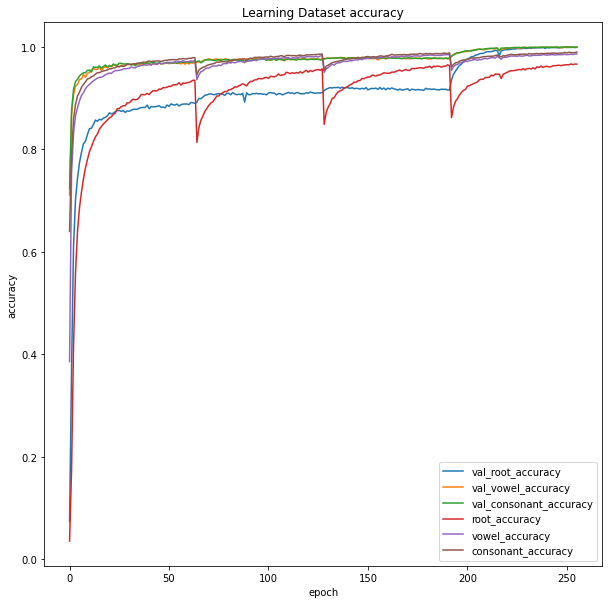

In [37]:
plot_graph(records,'accuracy')

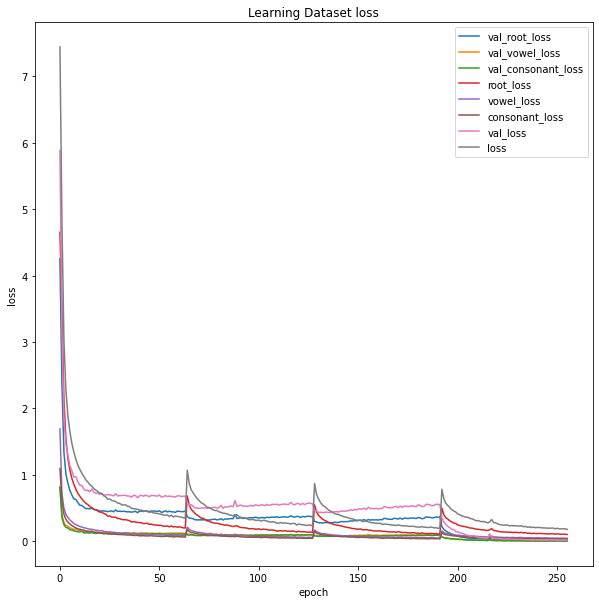

In [38]:
plot_graph(records,'loss')

In [18]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [24]:
row_id=[]
target=[]
for i in range(4):
    test_image=pd.read_parquet(PATH+'test_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    
    for j, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[j], axis=1)
    
    for k,id in enumerate(test_image.index.values):
        row_id+=[id+'_grapheme_root',id+'_vowel_diacritic',id+'_consonant_diacritic']
        target+=[preds_dict['grapheme_root'][k],preds_dict['vowel_diacritic'][k],preds_dict['consonant_diacritic'][k]]

submission = pd.DataFrame({'row_id': row_id, 'target': target})
submission.to_csv('sample_submission.csv', index=False)
print(submission)


                         row_id  target
0          Test_0_grapheme_root       3
1        Test_0_vowel_diacritic       0
2    Test_0_consonant_diacritic       0
3          Test_1_grapheme_root      93
4        Test_1_vowel_diacritic       0
5    Test_1_consonant_diacritic       2
6          Test_2_grapheme_root      19
7        Test_2_vowel_diacritic       0
8    Test_2_consonant_diacritic       0
9          Test_3_grapheme_root     115
10       Test_3_vowel_diacritic       0
11   Test_3_consonant_diacritic       0
12         Test_4_grapheme_root      55
13       Test_4_vowel_diacritic       0
14   Test_4_consonant_diacritic       4
15         Test_5_grapheme_root     115
16       Test_5_vowel_diacritic       0
17   Test_5_consonant_diacritic       2
18         Test_6_grapheme_root     147
19       Test_6_vowel_diacritic       5
20   Test_6_consonant_diacritic       9
21         Test_7_grapheme_root     137
22       Test_7_vowel_diacritic       0
23   Test_7_consonant_diacritic       7

In [20]:
temp = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
preds_dict = {}
preds_dict['grapheme_root']=[]
preds_dict['consonant_diacritic']=[]
preds_dict['vowel_diacritic']=[]


In [21]:
y_test=pd.read_csv(PATH+'train.csv')
for i in range(4):
    test_image=pd.read_parquet(PATH+'train_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    for j, p in enumerate(temp):
        temp[p] = np.argmax(preds[j], axis=1)
    preds_dict['grapheme_root'].extend(temp['grapheme_root'])
    preds_dict['vowel_diacritic'].extend(temp['vowel_diacritic'])
    preds_dict['consonant_diacritic'].extend(temp['consonant_diacritic'])
    #print(len(preds_dict['grapheme_root']))

In [22]:
root_acc=accuracy_score(y_test['grapheme_root'],preds_dict['grapheme_root'])
vowel_acc=accuracy_score(y_test['vowel_diacritic'],preds_dict['vowel_diacritic'])
consonant_acc=accuracy_score(y_test['consonant_diacritic'],preds_dict['consonant_diacritic'])

print('Grapheme Roots accuracy: ',root_acc)
print('Vowel Diacritic accuracy: ',vowel_acc)
print('consonant Diacritic accuracy: ',consonant_acc)

acc=[root_acc,vowel_acc,consonant_acc]
score=np.average(acc,weights=[2,1,1])
print('Score: ',score)

Grapheme Roots accuracy:  0.9537691694881498
Vowel Diacritic accuracy:  0.9875124477195778
consonant Diacritic accuracy:  0.9871091416052579
Score:  0.9705399820752839
